# Word embedding with random, sparse HD vectors

In [1]:

using Plots
using Glob
using ProgressMeter
using MultivariateStats
using Conda

#===
 import Pkg; Conda.add("Nltk", :hd)
 env = :hd
 Conda.add("Nltk", env)
===#

ENV["PYTHON"] = "/usr/bin/python3"
using Pkg
Pkg.build("PyCall")

using PyCall

@pyimport nltk.stem as NLTK_STEM
@pyimport nltk.corpus as NLTK_CORPUS;


   Building Conda ─→ `~/.julia/packages/Conda/3rPhK/deps/build.log`
   Building PyCall → `~/.julia/packages/PyCall/zqDXB/deps/build.log`
┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:399
└ @ PyCall /home/jair/.julia/packages/PyCall/zqDXB/src/PyCall.jl:399


In [2]:

#======================================
    basic, simple NLP from scratch
======================================#


stopWords = NLTK_CORPUS.stopwords[:words]("english")
filterWords = vcat([""], stopWords)
  
lemmatizer = NLTK_STEM.WordNetLemmatizer()
#stemmer = NLTK_STEM.SnowballStemmer("english")


function largestSentenceOnly(corpus)
    maxCorpus = maximum(map(c -> length(c), corpus))
    for c in corpus
        if length(c) == maxCorpus
            return c
        end
    end
end


function parseTxt2BoW(text)
    # 1. decompose into sentences
    # 2. sentences -> Nag of Words
    
    function lowerCase(wrd)
       try
            lowercase(wrd) |> 
                (W -> filter(s -> !(s in ['\"']), W)) |>  # , '-', '+', '~'
                    lemmatizer[:lemmatize]
        catch
            wrd
        end
    end
    
    function massageText(wrds)
        # filter stop words
        wrds = filter(w -> !(w in filterWords), wrds)
        # filter words with symbols
        filter(w -> true, wrds) |> # !(w[1] in ['#', '@']), wrds)
            (W -> map(w -> lowerCase(w), W))
    end
    
    
    split(text, ['.','!','?']) |> 
        (txt -> map(t -> (split(t, [' ',',','/','\'',';',':',]) |> massageText), 
                    txt)) |> #largestSentenceOnly |>
        (T -> vcat(T...)) |>
        (T -> filter(x -> x != "", T))
end



┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[2]:1
└ @ Core In[2]:1


parseTxt2BoW (generic function with 1 method)

### Process Data

In [3]:
dicCnt = Dict()

dirPATH = "data/dataFairyTales"
fileNames = glob("*", dirPATH);

allData = []
@showprogress for fn in fileNames
    
    data = map(lowercase, readlines(fn)) |>
            (V -> map(parseTxt2BoW, V))
    
    for w in vcat(data...)
        v = get(dicCnt, w, 0)
        dicCnt[w] = v+1
    end
    
    [push!(allData, d) for d in data]

end

N = length(allData)


┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = (::var"#lowerCase#16")(::SubString{String}) at In[2]:30
└ @ Main ./In[2]:30
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


65000

### Important words within fairy tales

In [4]:

wrds = ["head",
        "hand",
        "night",
        "day",
        "mother",
        "wife",
        "girl",
        "daughter",
        "queen",
        "princess",
        "man",
        "king",
        "father",
        "son",
        "giant",
        "tree",
        "wood",
        "house",
        "time",
        "home"];


### Encoding Model

In [5]:

include("../src/modelHDSparse.jl")

n = 5000
w = 2

# We build SDRs dictionary "as you go"
dicEncodingModel = Dict(:N => n, :W => w);

dicSDMs = Dict()
@showprogress for k in keys(dicCnt)
     HDSparse.encodeOnTheFly(dicSDMs, dicEncodingModel, k)
end

dicEmbeddings = map(w -> w => zeros(n), wrds) |> Dict;


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


### Build simple embedding

In [10]:

TFIDFOn = false

function weightTFIDF(wrd)
    tf = dicCnt[wrd] 
    TFIDFOn ? (tf/N * log(10, N/tf)) : 1
end

function takeNeighbours(data, nbNeigh)
    
    L = length(data)
    
    for i=1:L
        
        wrd = data[i]
        
        if haskey(dicEmbeddings, wrd) 
            
            idces = filter(j -> j!=i, max(i-nbNeigh, 1):min(i+nbNeigh, L))
            weights = map(j -> weightTFIDF(data[j]), idces)
            hdvecs = map(j -> get(dicSDMs, data[j], sparsevec([],[], n)), idces)
            
            
            for (id, w, hdvec) in zip(idces, weights, hdvecs)
                    
                for idx in hdvec.nzind
                    dicEmbeddings[wrd][idx] =+ w
                end
            end
        end
        
    end
end

takeNeighbours (generic function with 1 method)

In [11]:
@showprogress map(d -> takeNeighbours(d, 1), allData);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


### 2D Visualisation of embeddings

┌ Warning: `classical_mds(D::AbstractMatrix, p::Int)` is deprecated, use `transform(fit(MDS, D, maxoutdim = p, distances = true))` instead.
│   caller = top-level scope at In[12]:26
└ @ Core In[12]:26
┌ Warning: Skipped marker arg cirle.
└ @ Plots /home/jair/.julia/packages/Plots/ninUP/src/args.jl:800


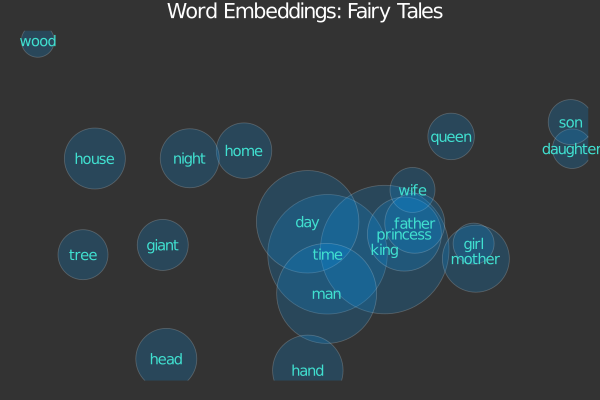

In [12]:

using MultivariateStats


# Build similarity matrix

sim(hdvec1, hdvec2) =  hdvec1'hdvec2 / (hdvec1'hdvec1*hdvec2'hdvec2)^.5


nbE = length(dicEmbeddings)
mat = zeros(nbE, nbE)
vEmbeddings = collect(keys(dicEmbeddings))


for i=1:nbE
    for j=1:nbE
        w, v = vEmbeddings[i], vEmbeddings[j]
        wec, vec = dicEmbeddings[w], 
                        dicEmbeddings[v]
        mat[i, j] = sim(wec, vec)
    end
end


D = gram2dmat(mat)
mds = classical_mds(D, 2);

weights = [dicCnt[w]/20 for w in vEmbeddings]

scatter(mds[1,:], mds[2,:],m=(weights, :cirle, weights),
        bg = RGB(0.2, 0.2, 0.2),  markeralpha = 0.2, 
        legend = false,
        axis=nothing,border=:none,
        title="Word Embeddings: Fairy Tales")

annotate!([(mds[1,i], mds[2,i], Plots.text(vEmbeddings[i], 10,  :turquoise, :center)) for i=1:nbE])


In [13]:
# savefig("images/fairyTales.png")